# **Rotterdam**

After doing some tests and knowing the issues with data.. We decided to forecast separately for each location for the 5 artikels


The estimation is for each artikel separately. We take data start point as 2012 for Rotterdam. And we take weekly peaks

### The following steps are taken:

##### *Algorithm Validation*
- The algorithm is trained on data till 2019 and a prediction is done for 2020.
- This is validated against 2020 data.

##### *Analysis for 2021- Effect of Corona*
- The newly validated alogrithm is now trained until 2020 and a prediction is made for 2021.
- This shows the effect of corona

##### *Forecast for 2022*
- The newly validated alogrithm is now trained until 2021 and a prediction is made for 2022.

In [1]:
#loading libraries and functions
import os 
import sys
sys.path.append('/home/amey/Projects/BUKO_Forecasting/Modelling/model')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import forecasting_functions as ff
import importlib
from statsmodels.tsa.holtwinters import ExponentialSmoothing
dirname='/home/amey/Projects/BUKO_Forecasting/'
forecast_data=os.path.join(dirname,'Modelling','forecast_processed_data')

## **AHEK**

In [2]:

importlib.reload(ff)
region='Rotterdam'
artikel_code='AHEK'
start_year_train=2012
end_year_train=2019
artikel_ts,train_ts=ff.get_data_series(region,artikel_code,dirname,start_year_train,end_year_train)
print('Training series is:'+str(train_ts))
# train_ts=train_ts[1:]

Training series is:2011-12-18    2239.0
2011-12-25    2249.0
2012-01-01    2147.0
2012-01-08    1860.0
2012-01-15    1941.0
               ...  
2019-12-01    3637.0
2019-12-08    3543.0
2019-12-15    3277.0
2019-12-22    3308.0
2019-12-29    2981.0
Name: Net_week_art, Length: 420, dtype: float64


### ***Algorithm Validation***

Note that some time one needs to adjust the training time seires to have a correct prediction start.

#### Time series analysis

Now we plot a Auto correlation of the time series to see whether it correlates to a yearly data.

0.9603293100036944
0.6660700715006354
0.7005811568556904
0.6489198377833765
0.5695759317547036


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

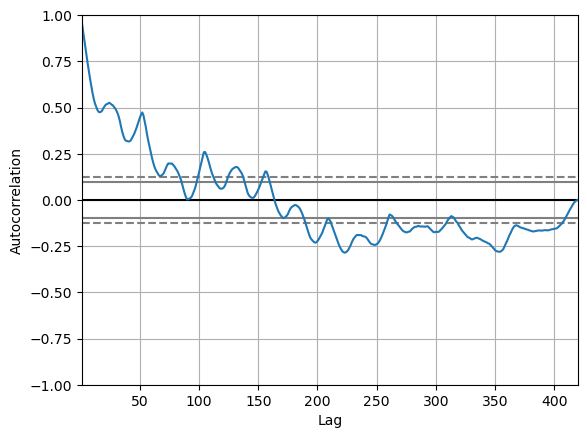

In [3]:
# lags based on weeks
lagvec=[1,25,52,52*2,int(52*2.5)]
for lag in lagvec:
    x=train_ts.autocorr(lag=lag)
    print(x)
pd.plotting.autocorrelation_plot(train_ts)

Seems like the series has a nice correlation for a year data (around 52 weeks) and also 26 weeks. The correlation goes down for 2 or larger years. 

#### Decomposing the series

The series can be decomposed into trend, sesonality and residual.

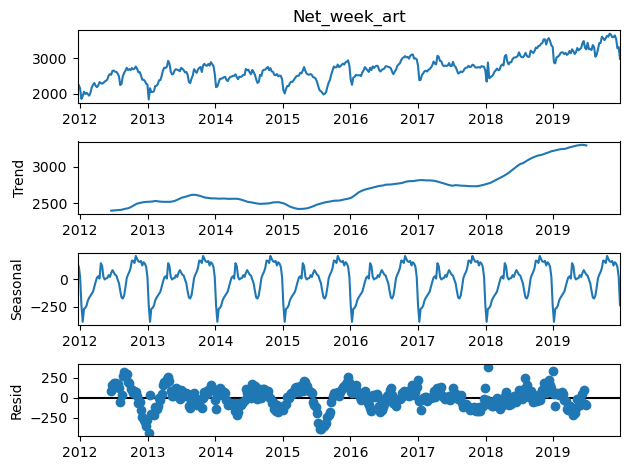

In [4]:
import statsmodels.api as sm
result=sm.tsa.seasonal_decompose(train_ts,model='add',period=52*1)

# plt.figure*()
fig1=result.plot()
fig1.tight_layout()

There is clearly an increasing trend which migh plateau in 2020. Importantly the seasonality pattern suggests that there are definite times in the year when certain orders are placed. 

**Important**

The residual (resid) gives a hint that these are spurious orders over the years which have will be difficult to be captured by the prediction algorithm. Thus, we can say that the uncertainty in our prediction would be around the max of this residual i.e. *250*


#### Model

In [5]:
model=ExponentialSmoothing(train_ts,damped_trend=False,trend='add',seasonal='add',seasonal_periods=52*1,initialization_method='estimated')
mod_result=model.fit()#location
artikel_data_loc=os.path.join(forecast_data,region,artikel_code)
summary_loc=os.path.join(artikel_data_loc,'model_summary.data')
with open(summary_loc,'w') as f:
    f.write(str(mod_result.summary()))


/home/amey/anaconda3/envs/buko_infra/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


Testing for the fitting of model versus observed data.

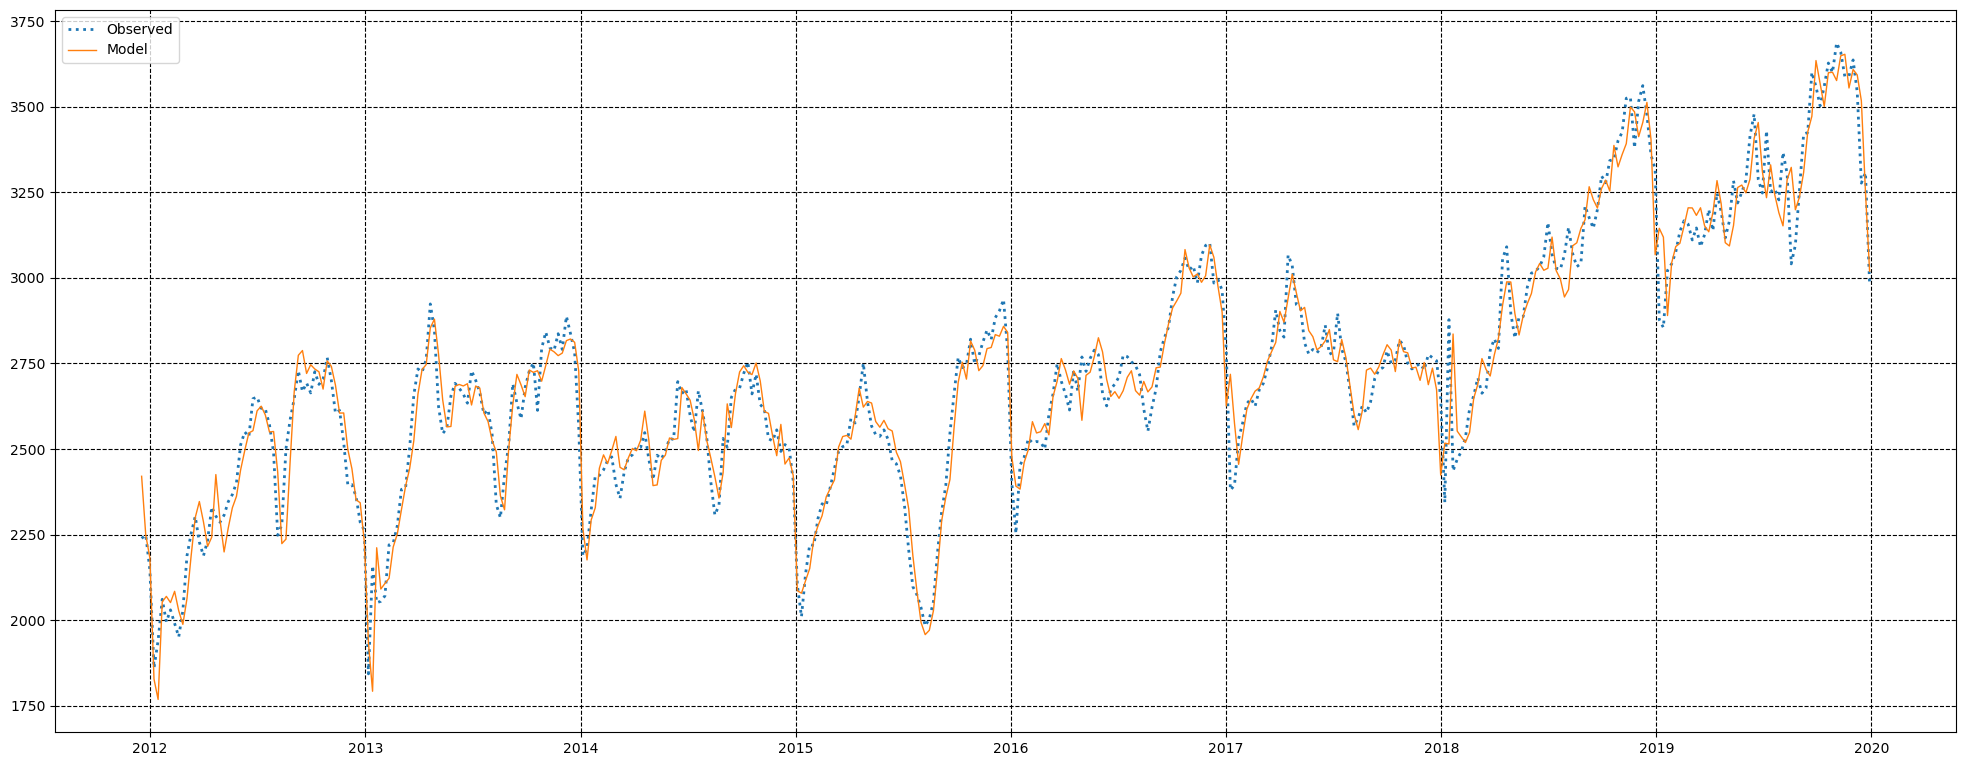

In [6]:
importlib.reload(ff)
fname=os.path.join(artikel_data_loc,'Testing_Fit.jpg')
ff.plot_mod_obs(train_ts,mod_result.fittedvalues,fname)


Testing for forecasting on 2020.

In [7]:
#2020 observations ts
start=int((2012-2007)*52-2)
end_int=int(2021-2012)
vald_ts=artikel_ts[start:start+52*end_int+3]
print(vald_ts)

2011-12-25    2249.0
2012-01-01    2147.0
2012-01-08    1860.0
2012-01-15    1941.0
2012-01-22    2061.0
               ...  
2020-11-29    3582.0
2020-12-06    3568.0
2020-12-13    3498.0
2020-12-20    3407.0
2020-12-27    3264.0
Name: Net_week_art, Length: 471, dtype: float64


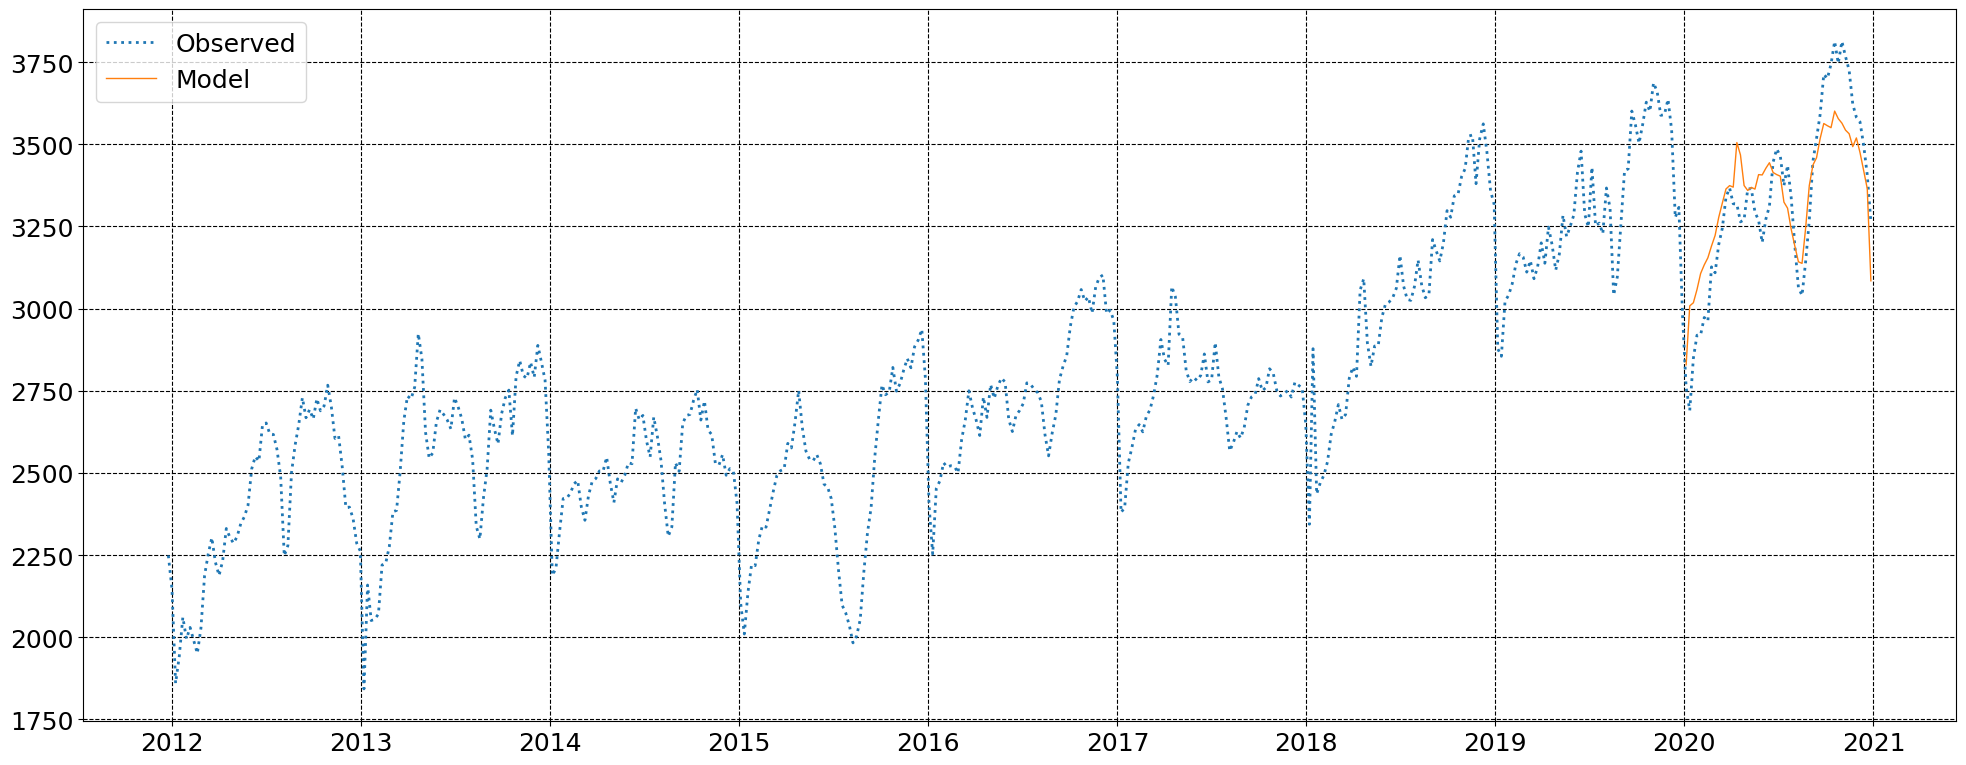

In [8]:
importlib.reload(ff)
fname=os.path.join(artikel_data_loc,'Validation_2020_Fit.jpg')
ff.plot_mod_obs(vald_ts,mod_result.forecast(52),fname)

### Corona Effect

Now the train_ts is replaced by the validation ts and a 2021 forecast is made

/home/amey/anaconda3/envs/buko_infra/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


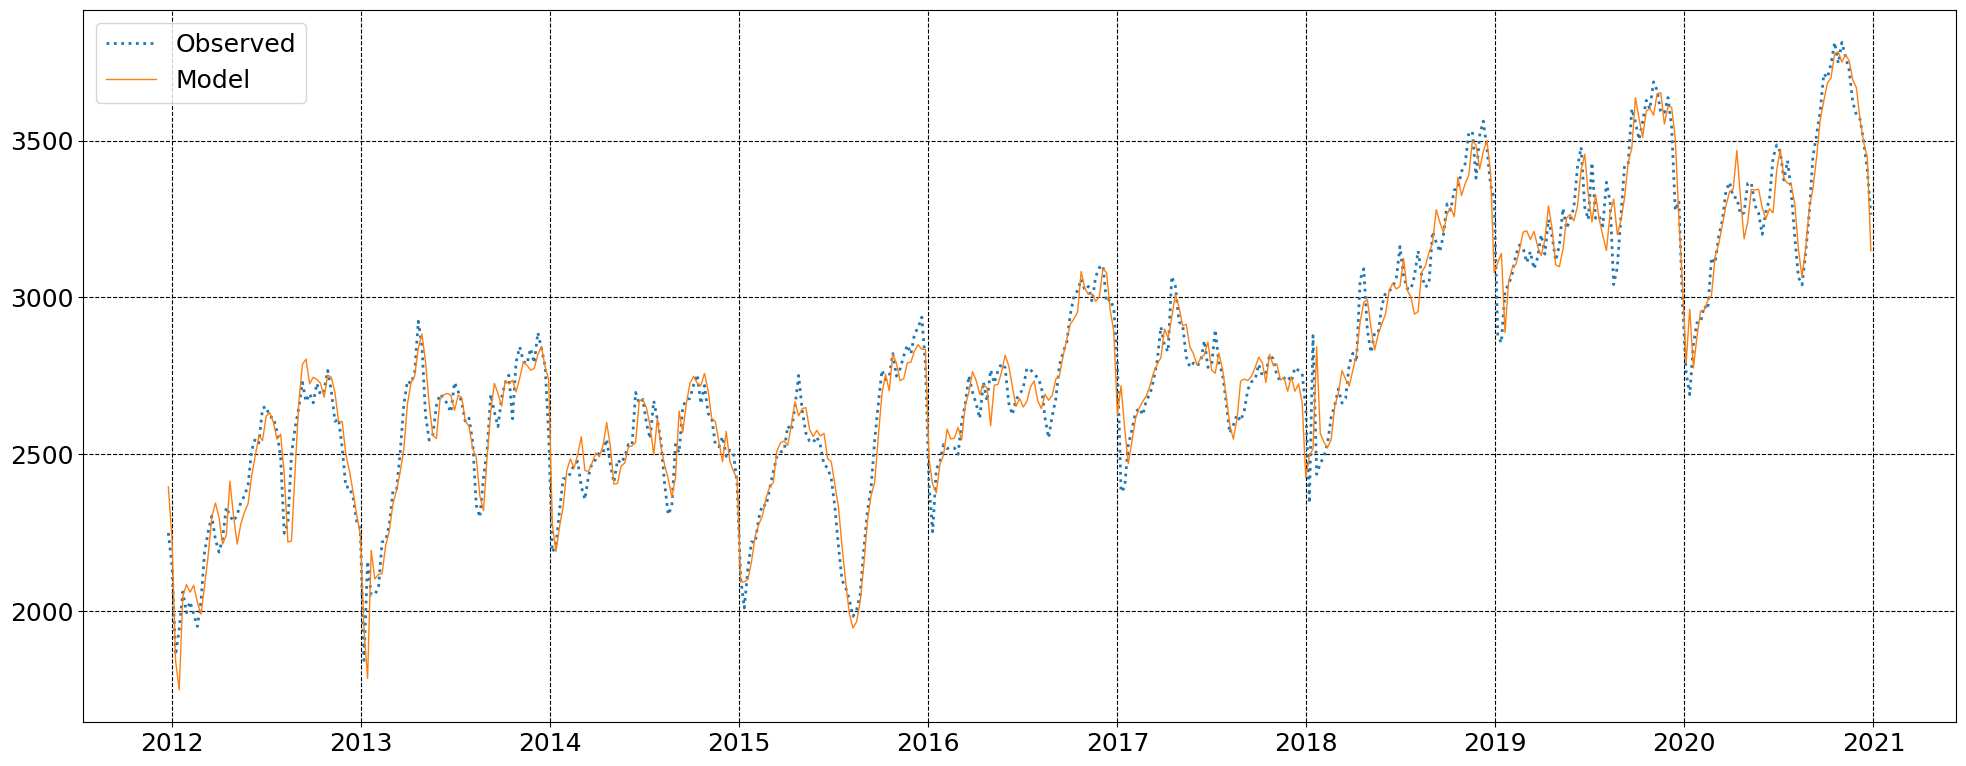

In [9]:
model=ExponentialSmoothing(vald_ts,damped_trend=False,trend='add',seasonal='add',seasonal_periods=52*1,initialization_method='estimated')
mod_result=model.fit()

fname=os.path.join(artikel_data_loc,'Corona_test_Fit.jpg')
ff.plot_mod_obs(vald_ts,mod_result.fittedvalues,fname)

Forecast for 2021

In [10]:
#2021 observations ts
start=int((2012-2007)*52-2)
end_int=int(2022-2012)
vald21_ts=artikel_ts[start:start+52*end_int+4]
print(vald21_ts)

2011-12-25    2249.0
2012-01-01    2147.0
2012-01-08    1860.0
2012-01-15    1941.0
2012-01-22    2061.0
               ...  
2021-11-28    3323.0
2021-12-05    3304.0
2021-12-12    3242.0
2021-12-19    3151.0
2021-12-26    3090.0
Name: Net_week_art, Length: 523, dtype: float64


In [11]:
#2021 forecast time series
forecast_2021=mod_result.forecast(52)
forecast_2021=forecast_2021.round()
df=pd.DataFrame(forecast_2021,columns=['Net_Artikels'])
fname=os.path.join(artikel_data_loc,'forecast_21.csv')
pd.Series.to_csv(df,fname)

Plotting against observed

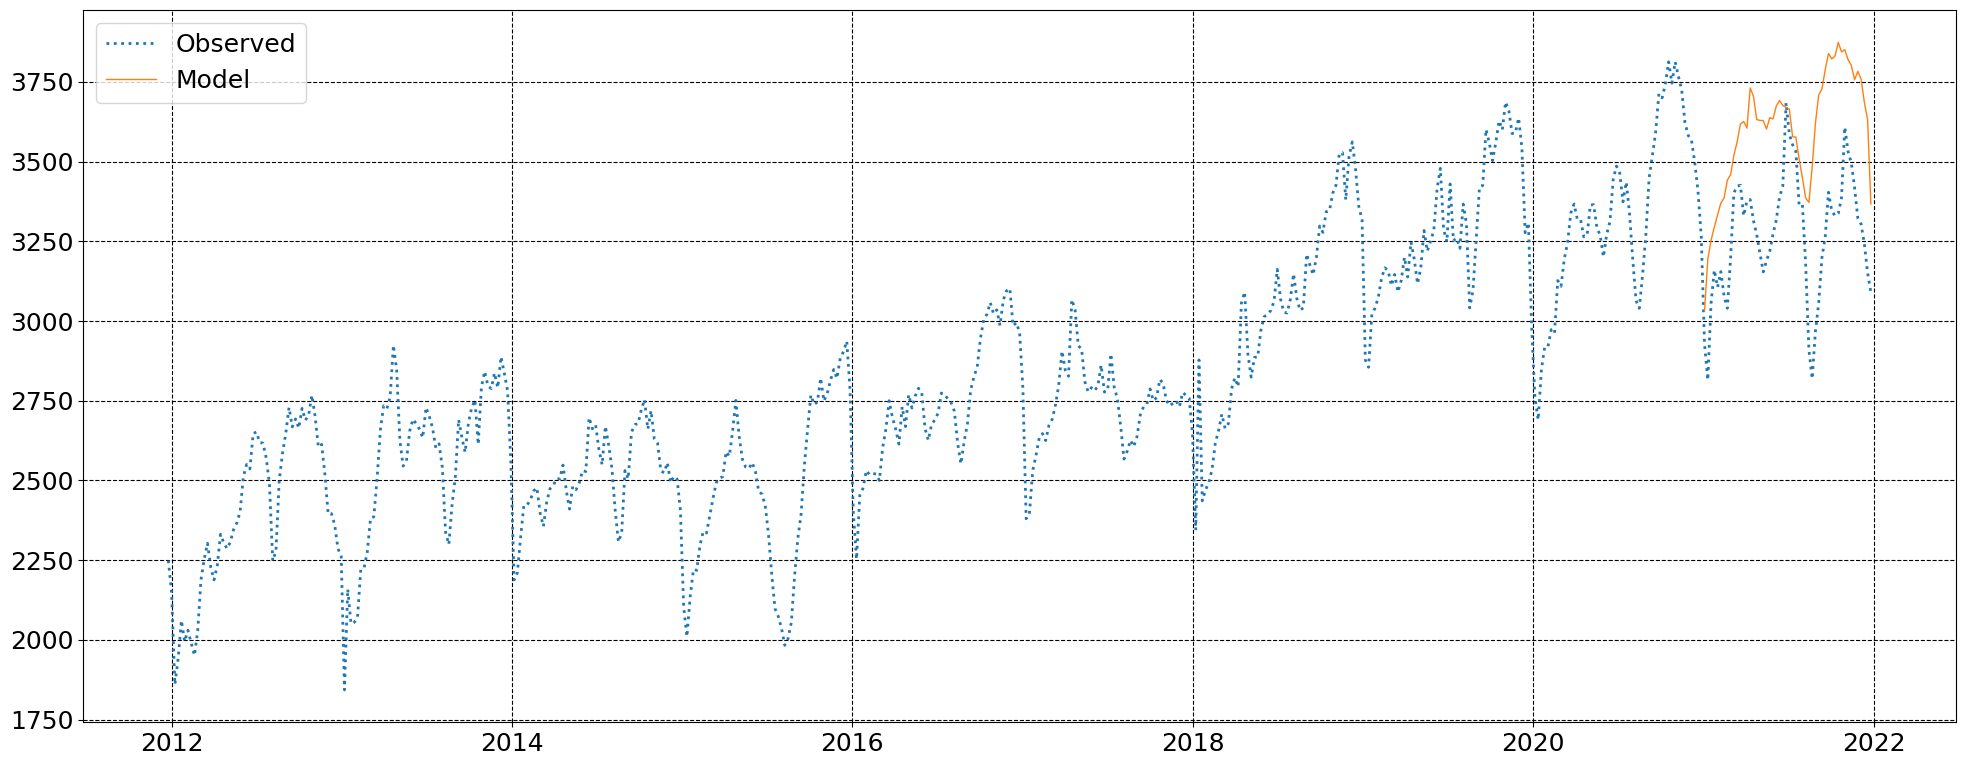

In [12]:
fname=os.path.join(artikel_data_loc,'Corona_effect.jpg')
ff.plot_mod_obs(vald21_ts,forecast_2021,fname)

### Forecast 2022

Train data till 2021


/home/amey/anaconda3/envs/buko_infra/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


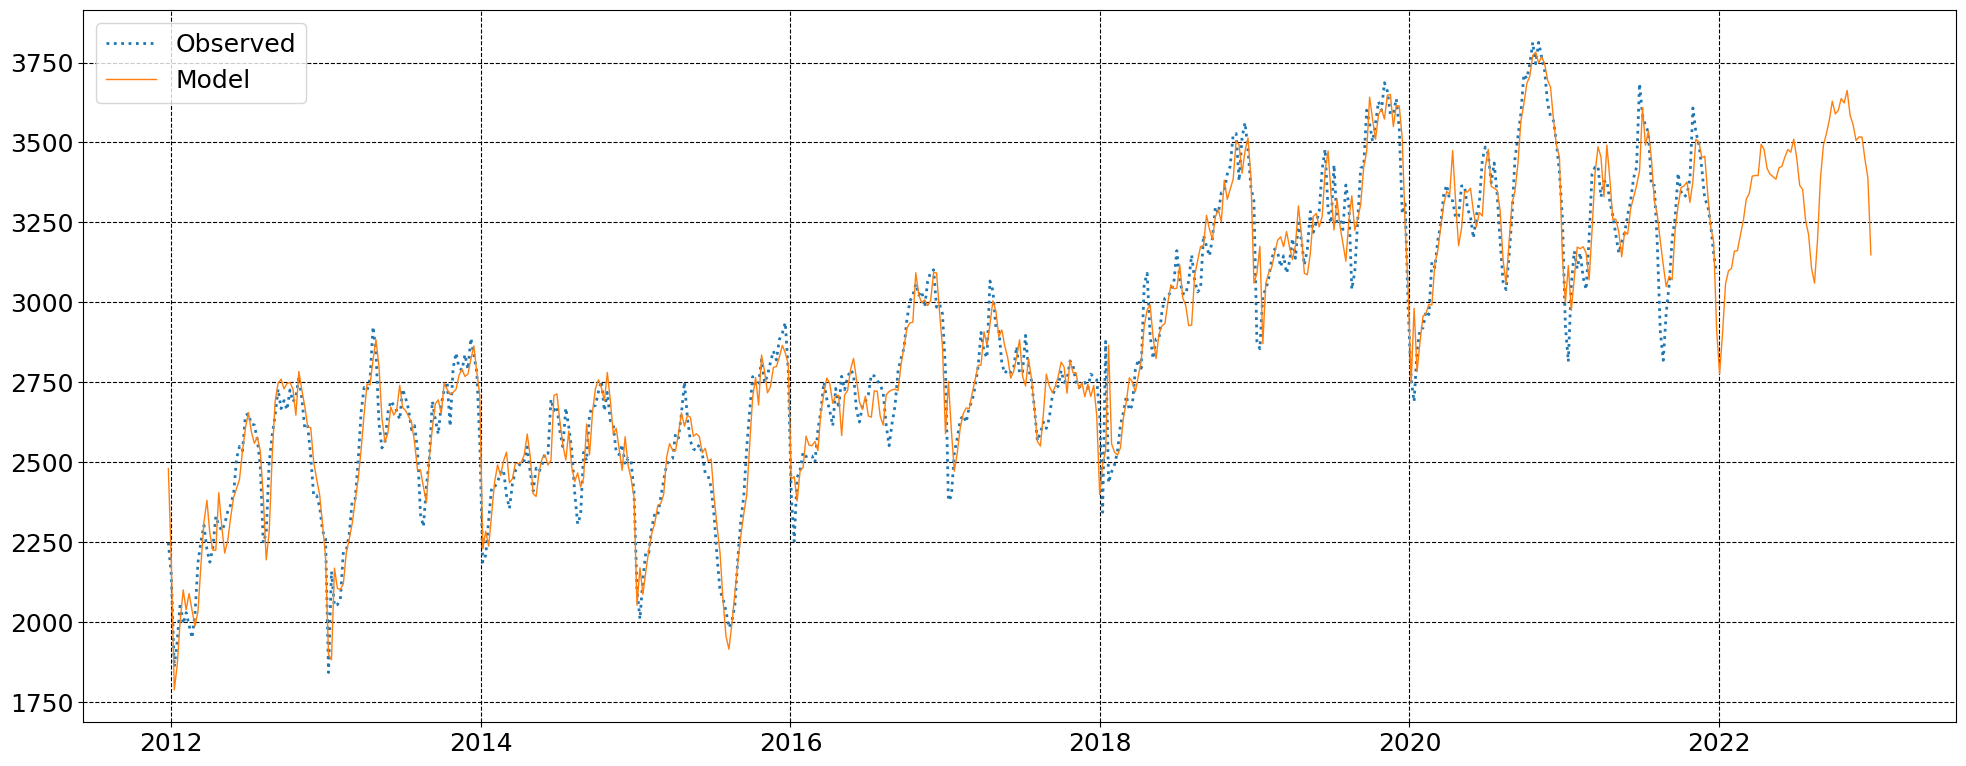

In [13]:
model=ExponentialSmoothing(vald21_ts,damped_trend=False,trend='add',seasonal='add',seasonal_periods=52*1,initialization_method='estimated')
mod_result=model.fit()
forecast22=mod_result.forecast(52)
mod_net=pd.concat([mod_result.fittedvalues,forecast22])
fname=os.path.join(artikel_data_loc,'Forecast22.jpg')
ff.plot_mod_obs(vald21_ts,mod_net,fname)

In [14]:
#2021 forecast time series
forecast_2022=mod_result.forecast(52)
forecast_2022=forecast_2022.round()
df=pd.DataFrame(forecast_2022,columns=['Net_Artikels'])
fname=os.path.join(artikel_data_loc,'forecast_22.csv')
pd.Series.to_csv(df,fname)

##### **END AHEK** 

## **A01-80-(30)**

In [2]:
importlib.reload(ff)
region='Rotterdam'
artikel_code='A01-80-(30)'
start_year_train=2012
end_year_train=2019
artikel_ts,train_ts=ff.get_data_series(region,artikel_code,dirname,start_year_train,end_year_train)
print('Training series is:'+str(train_ts))

Training series is:2011-12-18    576.0
2011-12-25    597.0
2012-01-01    518.0
2012-01-08    455.0
2012-01-15    483.0
              ...  
2019-12-01    814.0
2019-12-08    819.0
2019-12-15    803.0
2019-12-22    776.0
2019-12-29    708.0
Name: Net_week_art, Length: 420, dtype: float64


### ***Algorithm Validation***

Note that some time one needs to adjust the training time seires to have a correct prediction start.

#### Time series analysis

Now we plot a Auto correlation of the time series to see whether it correlates to a yearly data.

0.7938253569209951
0.3148859271982348
0.6135413609793979
0.5420153119671492
0.28594612695778104


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

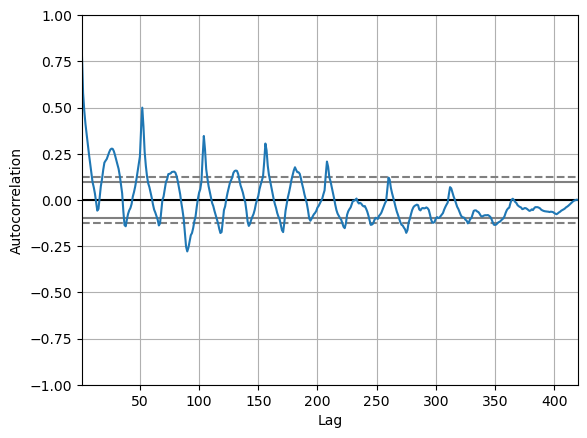

In [3]:
# lags based on weeks
lagvec=[1,25,52,52*2,int(52*2.5)]
for lag in lagvec:
    x=train_ts.autocorr(lag=lag)
    print(x)
pd.plotting.autocorrelation_plot(train_ts)

Seems like the series has a nice correlation for a year data (around 52 weeks) and also 26 weeks. The correlation goes down for 2 or larger years. 

#### Decomposing the series

The series can be decomposed into trend, sesonality and residual.

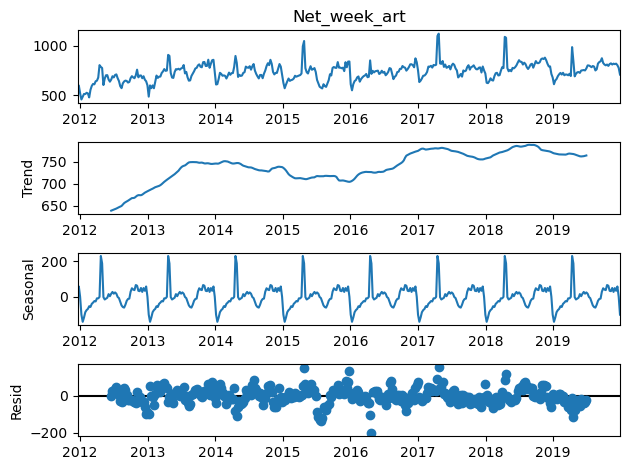

In [4]:
import statsmodels.api as sm
result=sm.tsa.seasonal_decompose(train_ts,model='add',period=52*1)
# fig=plt.figure(figsize=(8,16))
fig1=result.plot()
fig1.tight_layout()

There is clearly an increasing trend which is tending to plateau in 2020. Importantly the seasonality pattern suggests that there are definite times in the year when certain orders are placed. 

**Important**

The residual (resid) gives a hint that these are spurious orders over the years which have will be difficult to be captured by the prediction algorithm. Thus, we can say that the uncertainty in our prediction would be around the max of this residual i.e. *100*


#### Model

In [5]:
model=ExponentialSmoothing(train_ts[1:],damped_trend=False,trend='add',seasonal='mul',seasonal_periods=52*1,initialization_method='estimated')
mod_result=model.fit()
#location
artikel_data_loc=os.path.join(forecast_data,region,artikel_code)
summary_loc=os.path.join(artikel_data_loc,'model_summary.data')
with open(summary_loc,'w') as f:
    f.write(str(mod_result.summary()))

/home/amey/anaconda3/envs/buko_infra/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


Testing for the fitting of model versus observed data.

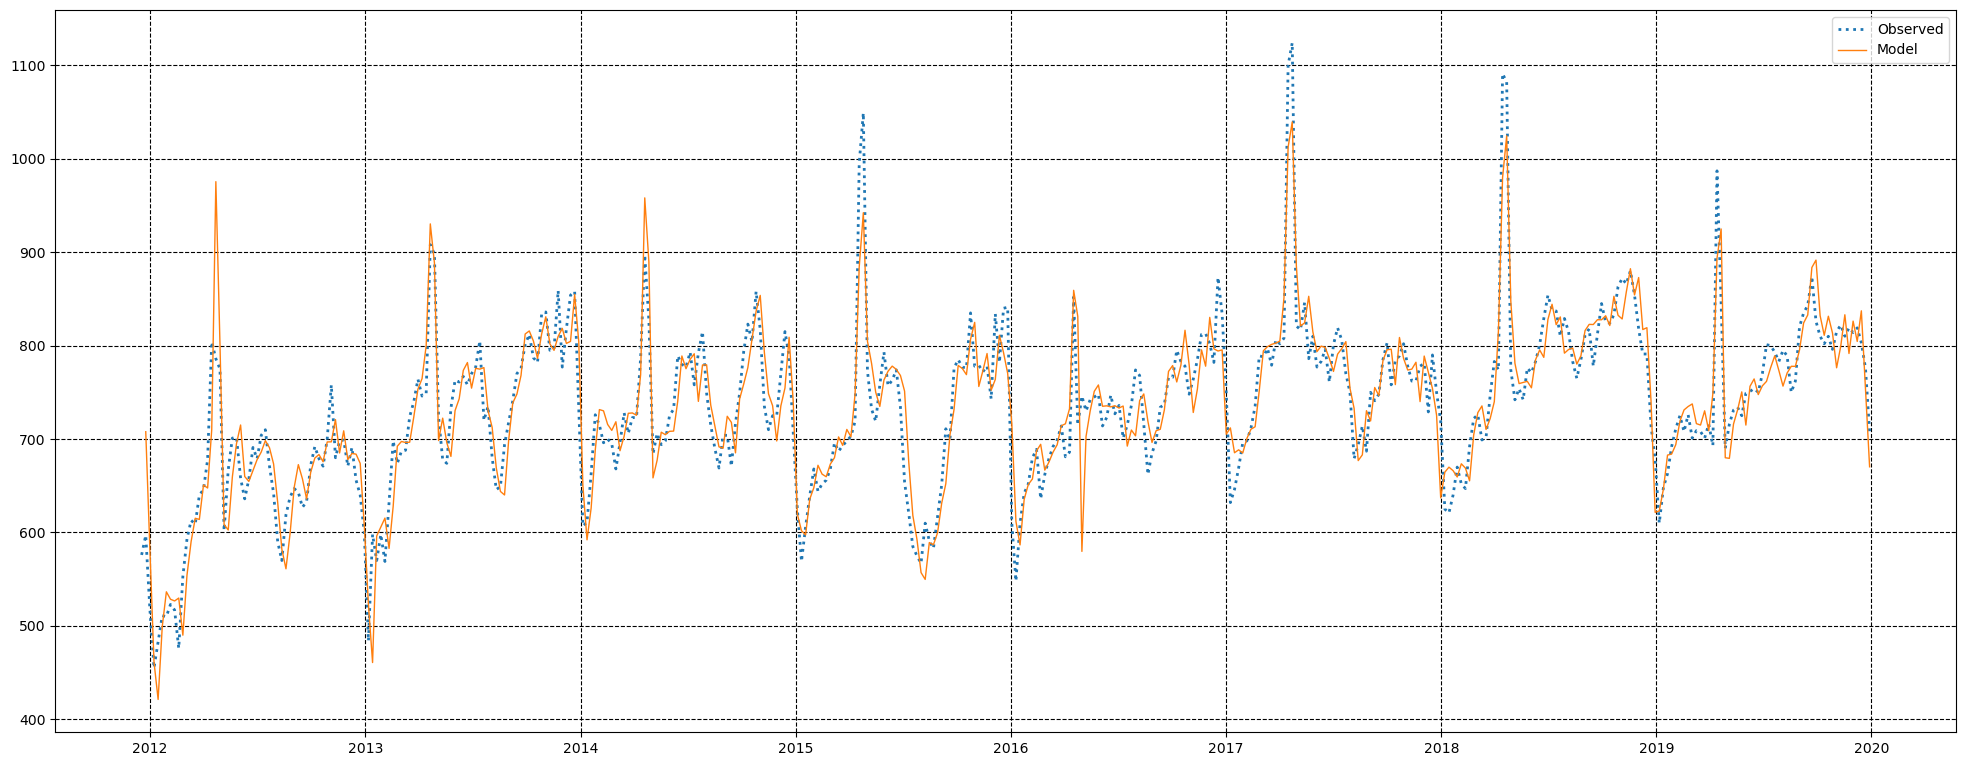

In [6]:
importlib.reload(ff)
fname=os.path.join(artikel_data_loc,'Testing_Fit.jpg')
ff.plot_mod_obs(train_ts,mod_result.fittedvalues,fname)


Testing for forecasting on 2020.

In [7]:
#2020 observations ts
start=int((2012-2007)*52-2)
end_int=int(2021-2012)
vald_ts=artikel_ts[start:start+52*end_int+3]
print(vald_ts)

2011-12-25    597.0
2012-01-01    518.0
2012-01-08    455.0
2012-01-15    483.0
2012-01-22    511.0
              ...  
2020-11-29    810.0
2020-12-06    813.0
2020-12-13    831.0
2020-12-20    822.0
2020-12-27    788.0
Name: Net_week_art, Length: 471, dtype: float64


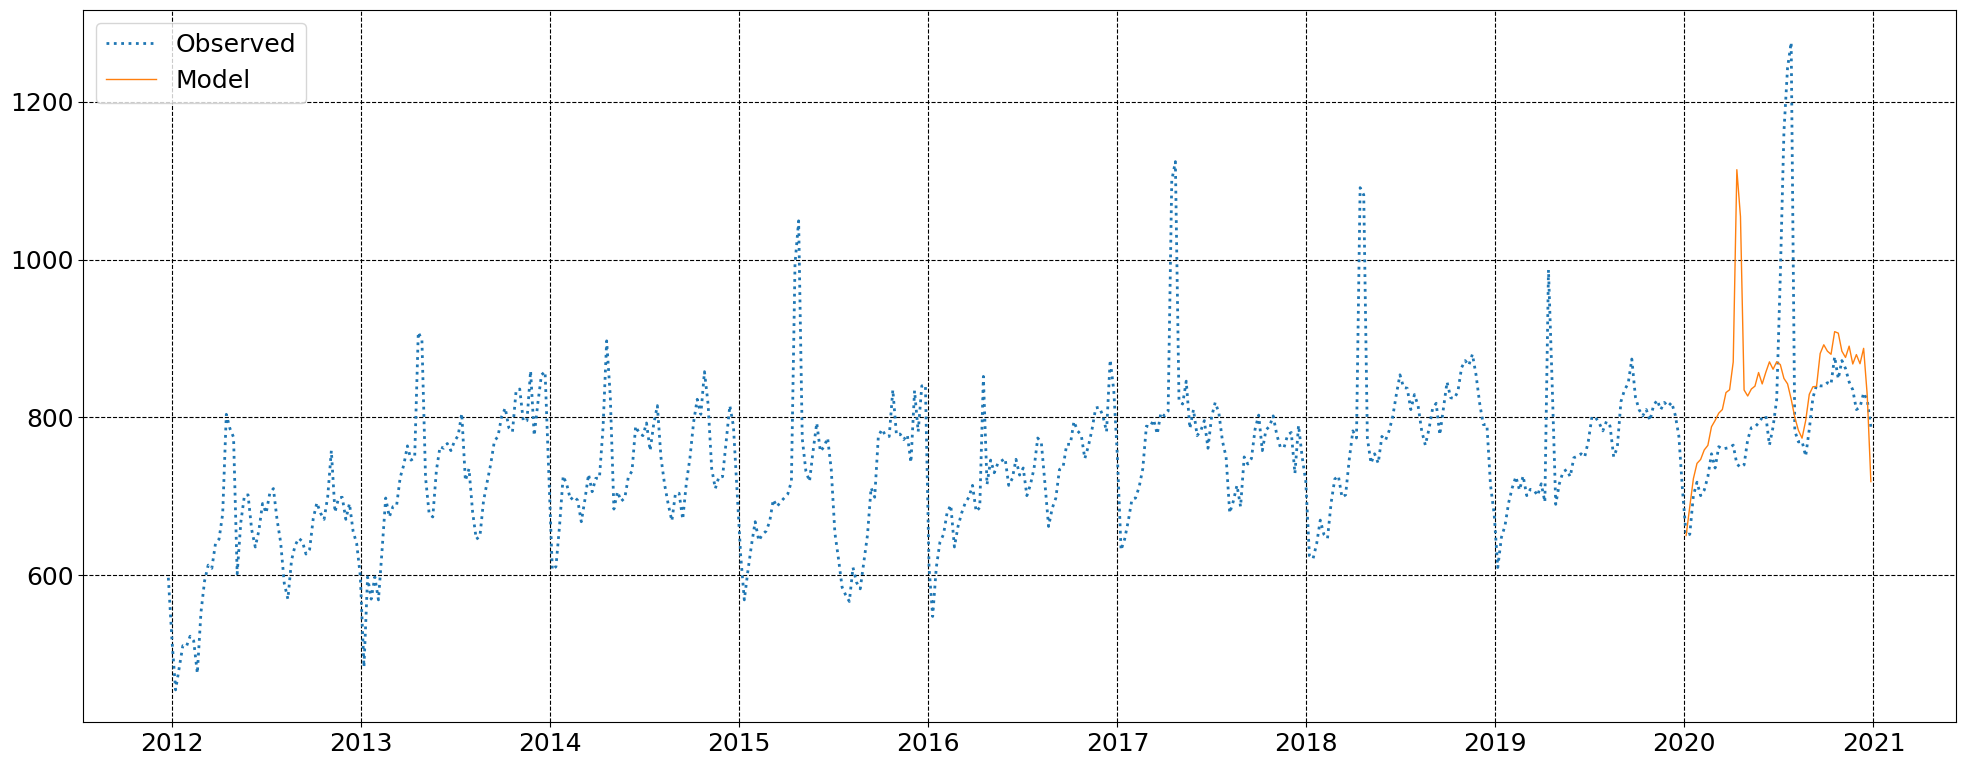

In [8]:
importlib.reload(ff)
fname=os.path.join(artikel_data_loc,'Validation_2020_Fit.jpg')
ff.plot_mod_obs(vald_ts,mod_result.forecast(52),fname)

### Corona Effect

Now the train_ts is replaced by the validation ts and a 2021 forecast is made

/home/amey/anaconda3/envs/buko_infra/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


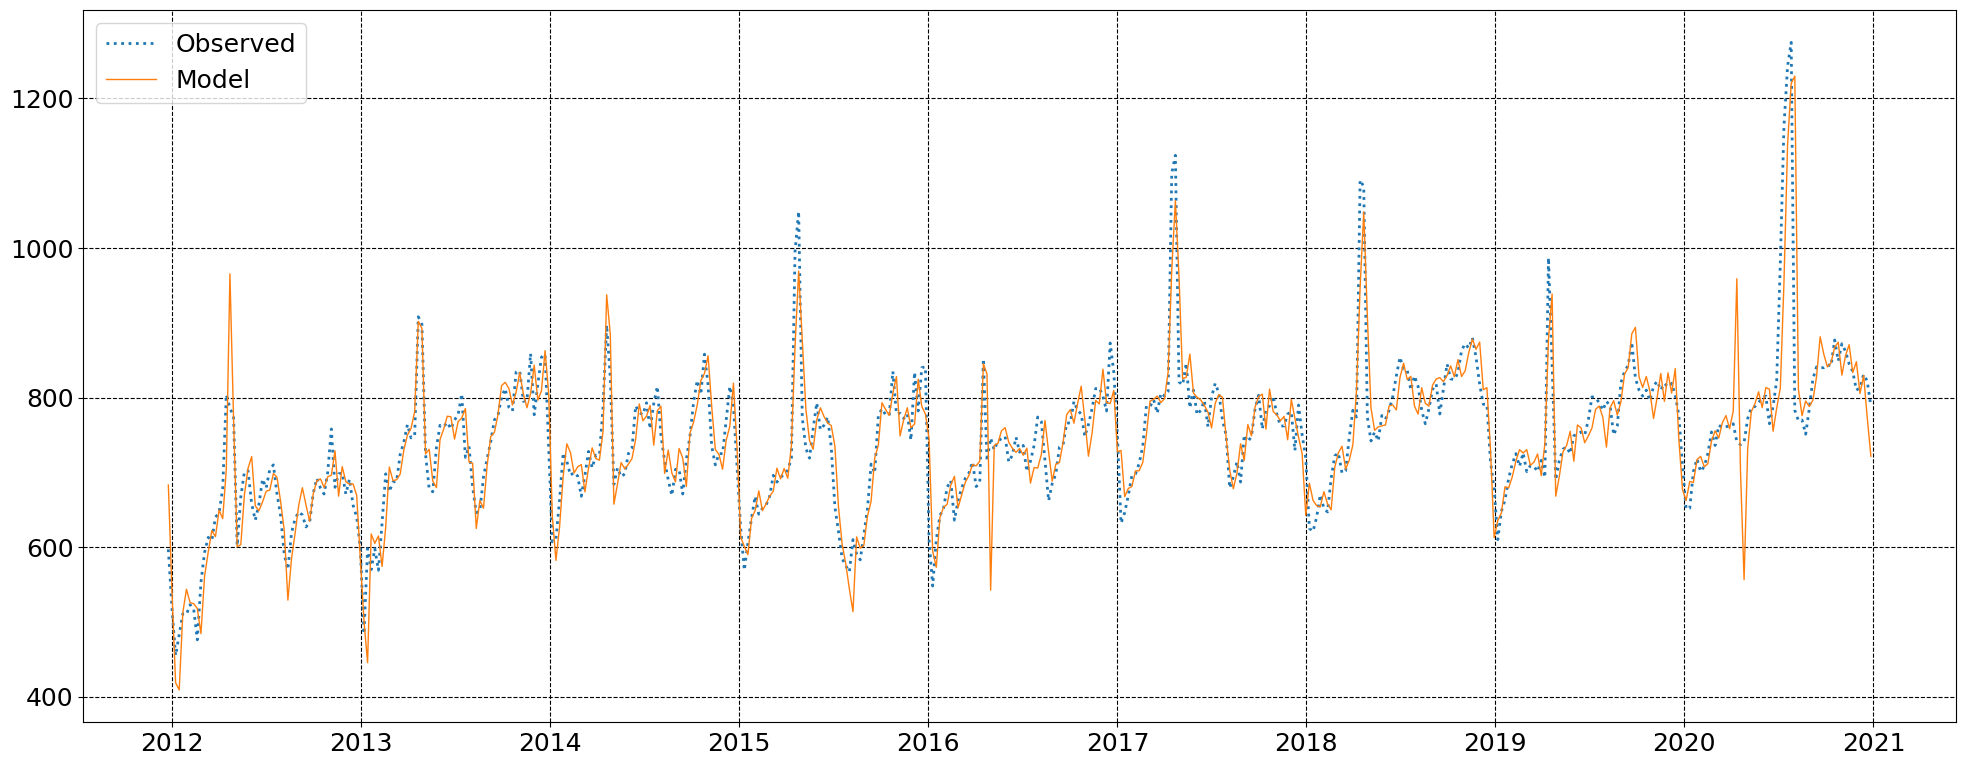

In [9]:
model=ExponentialSmoothing(vald_ts,damped_trend=False,trend='add',seasonal='add',seasonal_periods=52*1,initialization_method='estimated')
mod_result=model.fit()

fname=os.path.join(artikel_data_loc,'Corona_test_Fit.jpg')
ff.plot_mod_obs(vald_ts,mod_result.fittedvalues,fname)

Forecast for 2021

In [10]:
#2021 observations ts
start=int((2012-2007)*52-2)
end_int=int(2022-2012)
vald21_ts=artikel_ts[start:start+52*end_int+4]
print(vald21_ts)

2011-12-25    597.0
2012-01-01    518.0
2012-01-08    455.0
2012-01-15    483.0
2012-01-22    511.0
              ...  
2021-11-28    819.0
2021-12-05    821.0
2021-12-12    798.0
2021-12-19    798.0
2021-12-26    779.0
Name: Net_week_art, Length: 523, dtype: float64


In [11]:
#2021 forecast time series
forecast_2021=mod_result.forecast(52)
forecast_2021=forecast_2021.round()
df=pd.DataFrame(forecast_2021,columns=['Net_Artikels'])
fname=os.path.join(artikel_data_loc,'forecast_21.csv')
pd.Series.to_csv(df,fname)

Plotting against observed

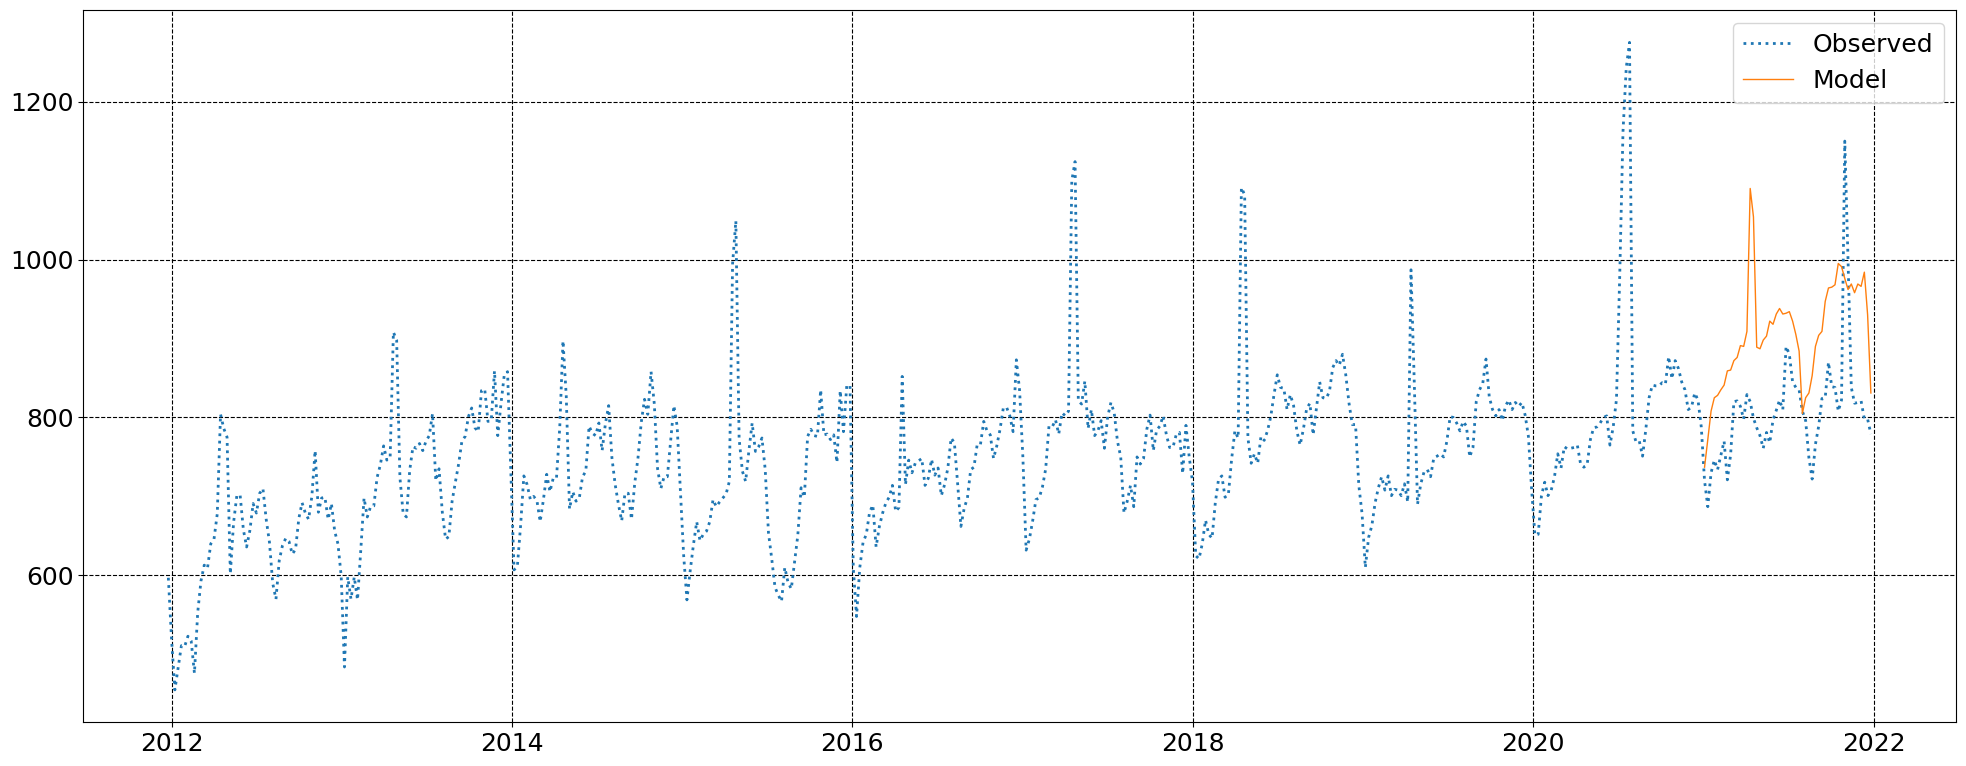

In [12]:
fname=os.path.join(artikel_data_loc,'Corona_effect.jpg')
ff.plot_mod_obs(vald21_ts,forecast_2021,fname)

### Forecast 2022

Train data till 2021


/home/amey/anaconda3/envs/buko_infra/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


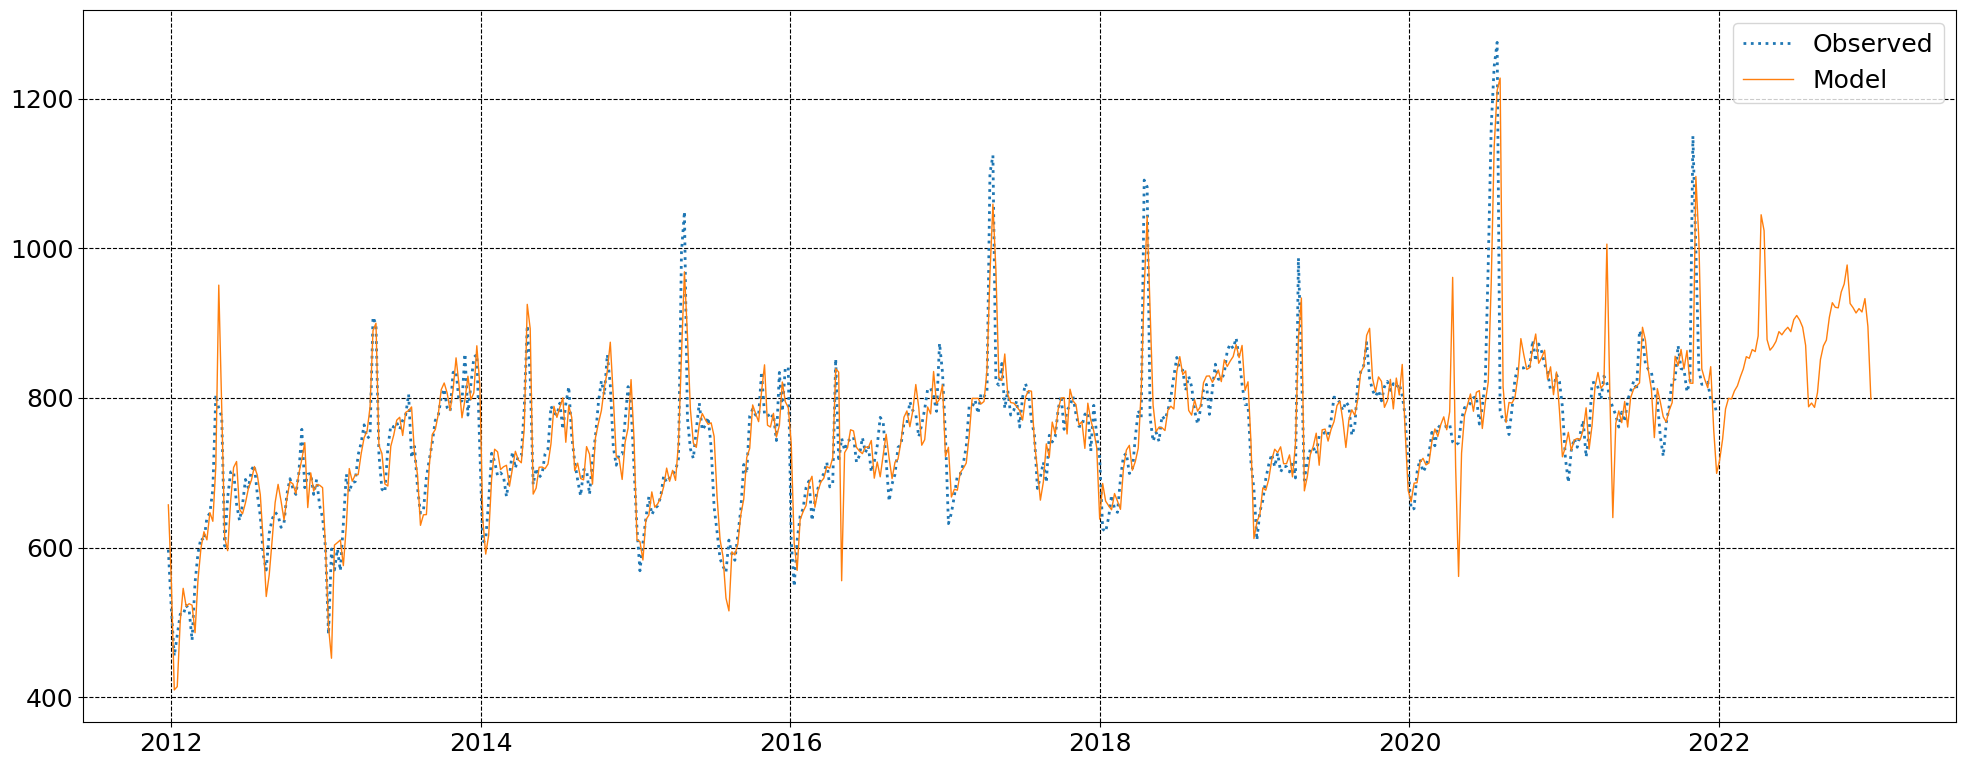

In [13]:
model=ExponentialSmoothing(vald21_ts,damped_trend=False,trend='add',seasonal='add',seasonal_periods=52*1,initialization_method='estimated')
mod_result=model.fit()
forecast22=mod_result.forecast(52)
mod_net=pd.concat([mod_result.fittedvalues,forecast22])
fname=os.path.join(artikel_data_loc,'Forecast22.jpg')
ff.plot_mod_obs(vald21_ts,mod_net,fname)

In [14]:
#2022 forecast time series
forecast_2022=mod_result.forecast(52)
forecast_2022=forecast_2022.round()
df=pd.DataFrame(forecast_2022,columns=['Net_Artikels'])
fname=os.path.join(artikel_data_loc,'forecast_22.csv')
pd.Series.to_csv(df,fname)

## **TB80120G**

In [ ]:
importlib.reload(ff)
region='Rotterdam'
artikel_code='TB80120G'
start_year_train=2012
end_year_train=2019
artikel_ts,train_ts=ff.get_data_series(region,artikel_code,dirname,start_year_train,end_year_train)
print('Training series is:'+str(train_ts))

Training series is:2011-12-18    576.0
2011-12-25    597.0
2012-01-01    518.0
2012-01-08    455.0
2012-01-15    483.0
              ...  
2019-12-01    814.0
2019-12-08    819.0
2019-12-15    803.0
2019-12-22    776.0
2019-12-29    708.0
Name: Net_week_art, Length: 420, dtype: float64


### ***Algorithm Validation***

Note that some time one needs to adjust the training time seires to have a correct prediction start.

#### Time series analysis

Now we plot a Auto correlation of the time series to see whether it correlates to a yearly data.

0.7938253569209951
0.3148859271982348
0.6135413609793979
0.5420153119671492
0.28594612695778104


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

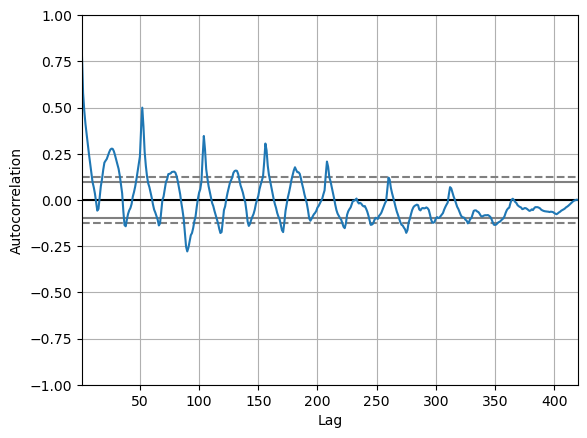

In [ ]:
# lags based on weeks
lagvec=[1,25,52,52*2,int(52*2.5)]
for lag in lagvec:
    x=train_ts.autocorr(lag=lag)
    print(x)
pd.plotting.autocorrelation_plot(train_ts)

Seems like the series has a nice correlation for a year data (around 52 weeks) and also 26 weeks. The correlation goes down for 2 or larger years. 

#### Decomposing the series

The series can be decomposed into trend, sesonality and residual.

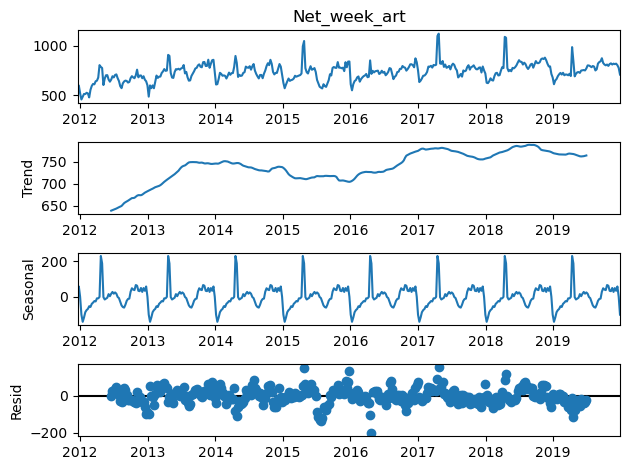

In [ ]:
import statsmodels.api as sm
result=sm.tsa.seasonal_decompose(train_ts,model='add',period=52*1)
# fig=plt.figure(figsize=(8,16))
fig1=result.plot()
fig1.tight_layout()

There is clearly an increasing trend which is tending to plateau in 2020. Importantly the seasonality pattern suggests that there are definite times in the year when certain orders are placed. 

**Important**

The residual (resid) gives a hint that these are spurious orders over the years which have will be difficult to be captured by the prediction algorithm. Thus, we can say that the uncertainty in our prediction would be around the max of this residual i.e. *100*


#### Model

In [ ]:
model=ExponentialSmoothing(train_ts[1:],damped_trend=False,trend='add',seasonal='mul',seasonal_periods=52*1,initialization_method='estimated')
mod_result=model.fit()
#location
artikel_data_loc=os.path.join(forecast_data,region,artikel_code)
summary_loc=os.path.join(artikel_data_loc,'model_summary.data')
with open(summary_loc,'w') as f:
    f.write(str(mod_result.summary()))

/home/amey/anaconda3/envs/buko_infra/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


Testing for the fitting of model versus observed data.

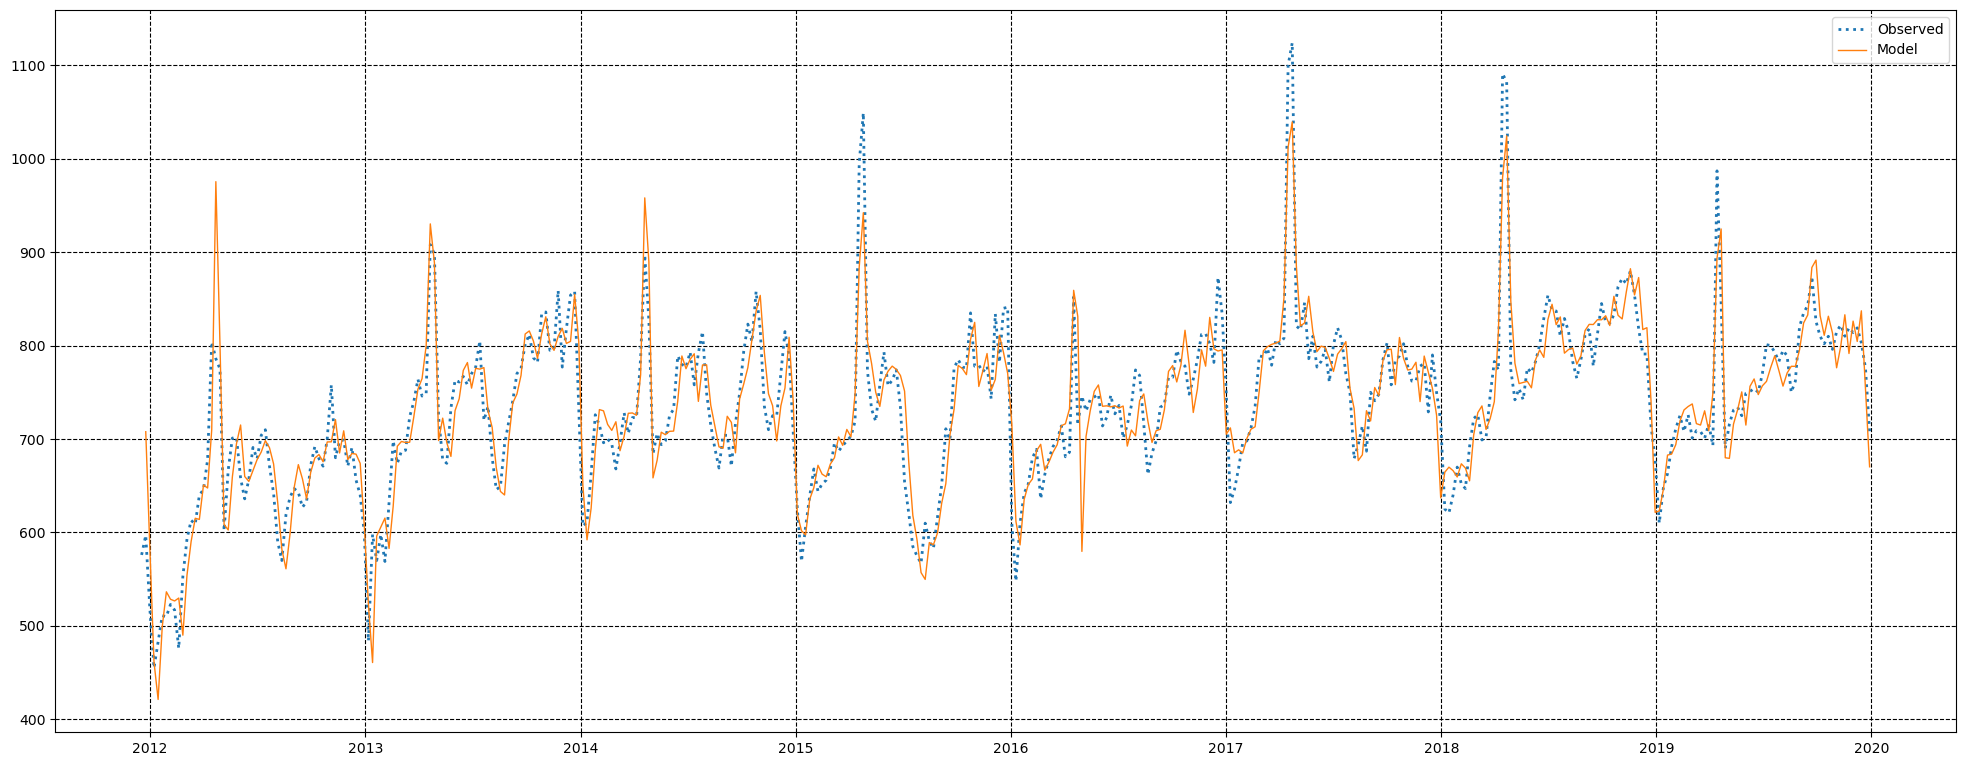

In [ ]:
importlib.reload(ff)
fname=os.path.join(artikel_data_loc,'Testing_Fit.jpg')
ff.plot_mod_obs(train_ts,mod_result.fittedvalues,fname)


Testing for forecasting on 2020.

In [ ]:
#2020 observations ts
start=int((2012-2007)*52-2)
end_int=int(2021-2012)
vald_ts=artikel_ts[start:start+52*end_int+3]
print(vald_ts)

2011-12-25    597.0
2012-01-01    518.0
2012-01-08    455.0
2012-01-15    483.0
2012-01-22    511.0
              ...  
2020-11-29    810.0
2020-12-06    813.0
2020-12-13    831.0
2020-12-20    822.0
2020-12-27    788.0
Name: Net_week_art, Length: 471, dtype: float64


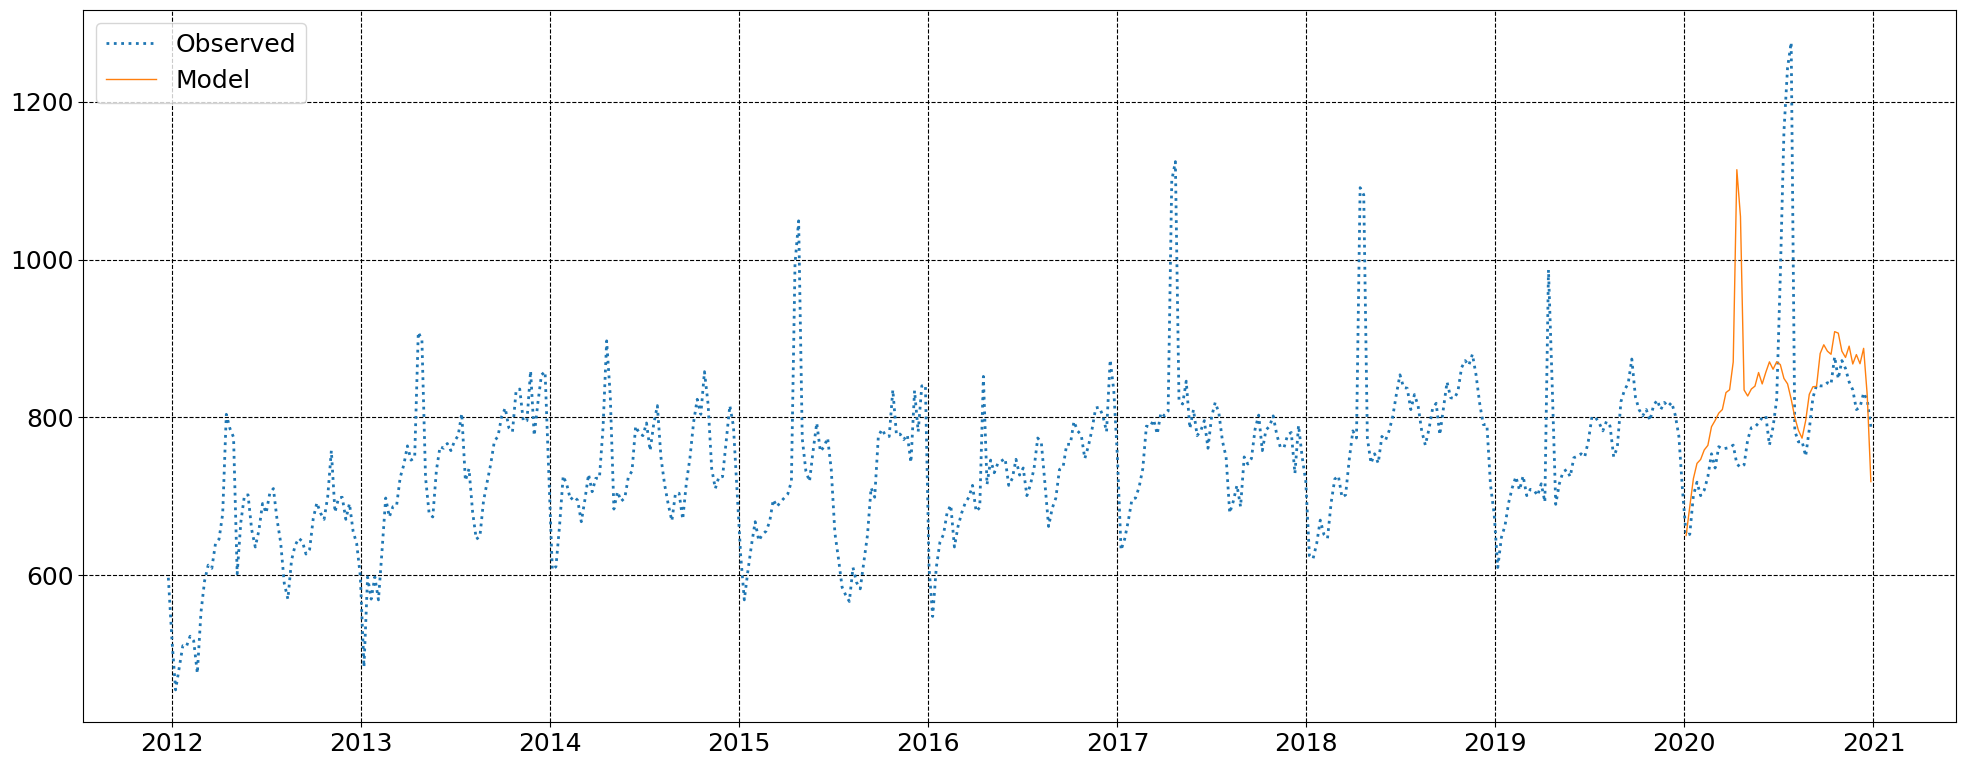

In [ ]:
importlib.reload(ff)
fname=os.path.join(artikel_data_loc,'Validation_2020_Fit.jpg')
ff.plot_mod_obs(vald_ts,mod_result.forecast(52),fname)

### Corona Effect

Now the train_ts is replaced by the validation ts and a 2021 forecast is made

/home/amey/anaconda3/envs/buko_infra/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


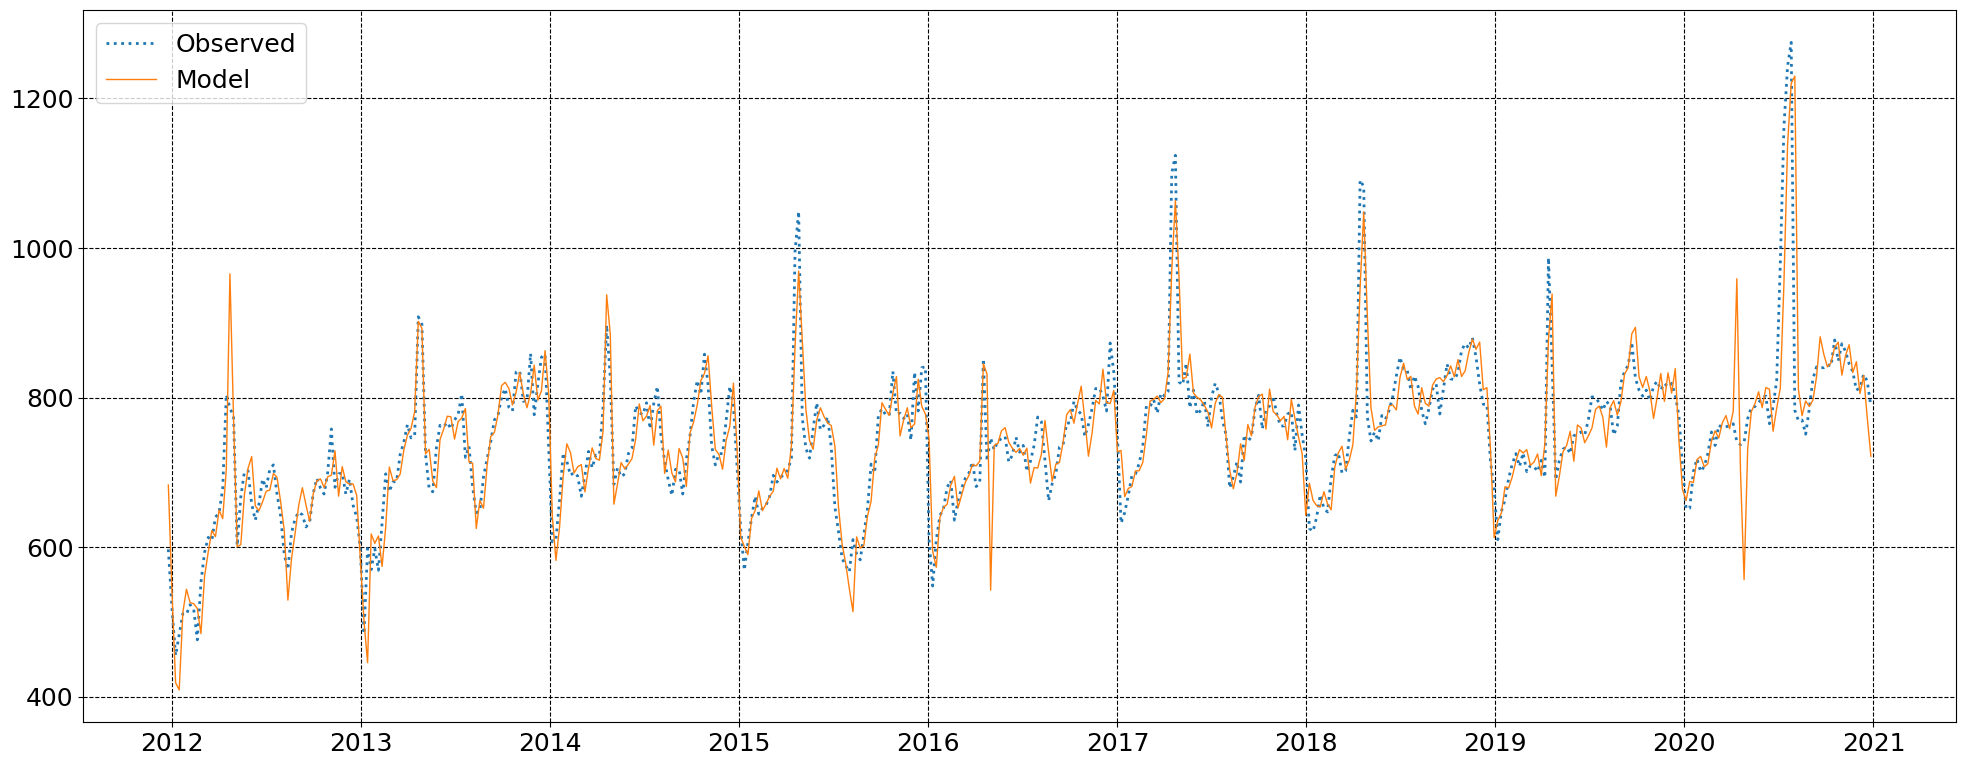

In [ ]:
model=ExponentialSmoothing(vald_ts,damped_trend=False,trend='add',seasonal='add',seasonal_periods=52*1,initialization_method='estimated')
mod_result=model.fit()

fname=os.path.join(artikel_data_loc,'Corona_test_Fit.jpg')
ff.plot_mod_obs(vald_ts,mod_result.fittedvalues,fname)

Forecast for 2021

In [ ]:
#2021 observations ts
start=int((2012-2007)*52-2)
end_int=int(2022-2012)
vald21_ts=artikel_ts[start:start+52*end_int+4]
print(vald21_ts)

2011-12-25    597.0
2012-01-01    518.0
2012-01-08    455.0
2012-01-15    483.0
2012-01-22    511.0
              ...  
2021-11-28    819.0
2021-12-05    821.0
2021-12-12    798.0
2021-12-19    798.0
2021-12-26    779.0
Name: Net_week_art, Length: 523, dtype: float64


In [ ]:
#2021 forecast time series
forecast_2021=mod_result.forecast(52)
forecast_2021=forecast_2021.round()
df=pd.DataFrame(forecast_2021,columns=['Net_Artikels'])
fname=os.path.join(artikel_data_loc,'forecast_21.csv')
pd.Series.to_csv(df,fname)

Plotting against observed

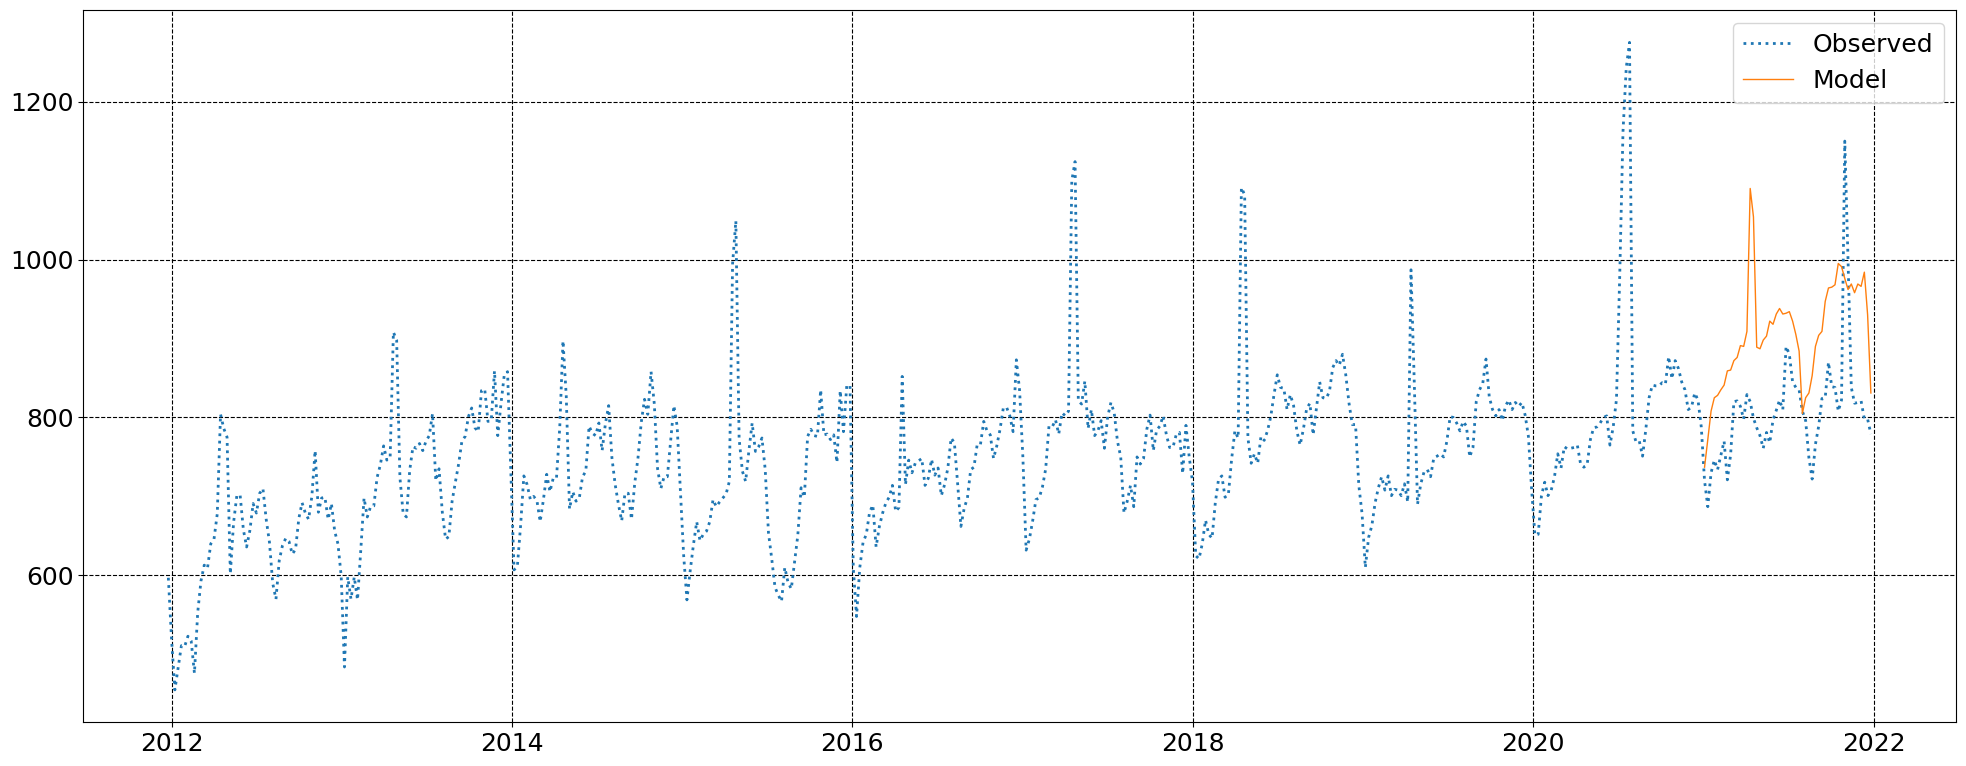

In [ ]:
fname=os.path.join(artikel_data_loc,'Corona_effect.jpg')
ff.plot_mod_obs(vald21_ts,forecast_2021,fname)

### Forecast 2022

Train data till 2021


/home/amey/anaconda3/envs/buko_infra/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


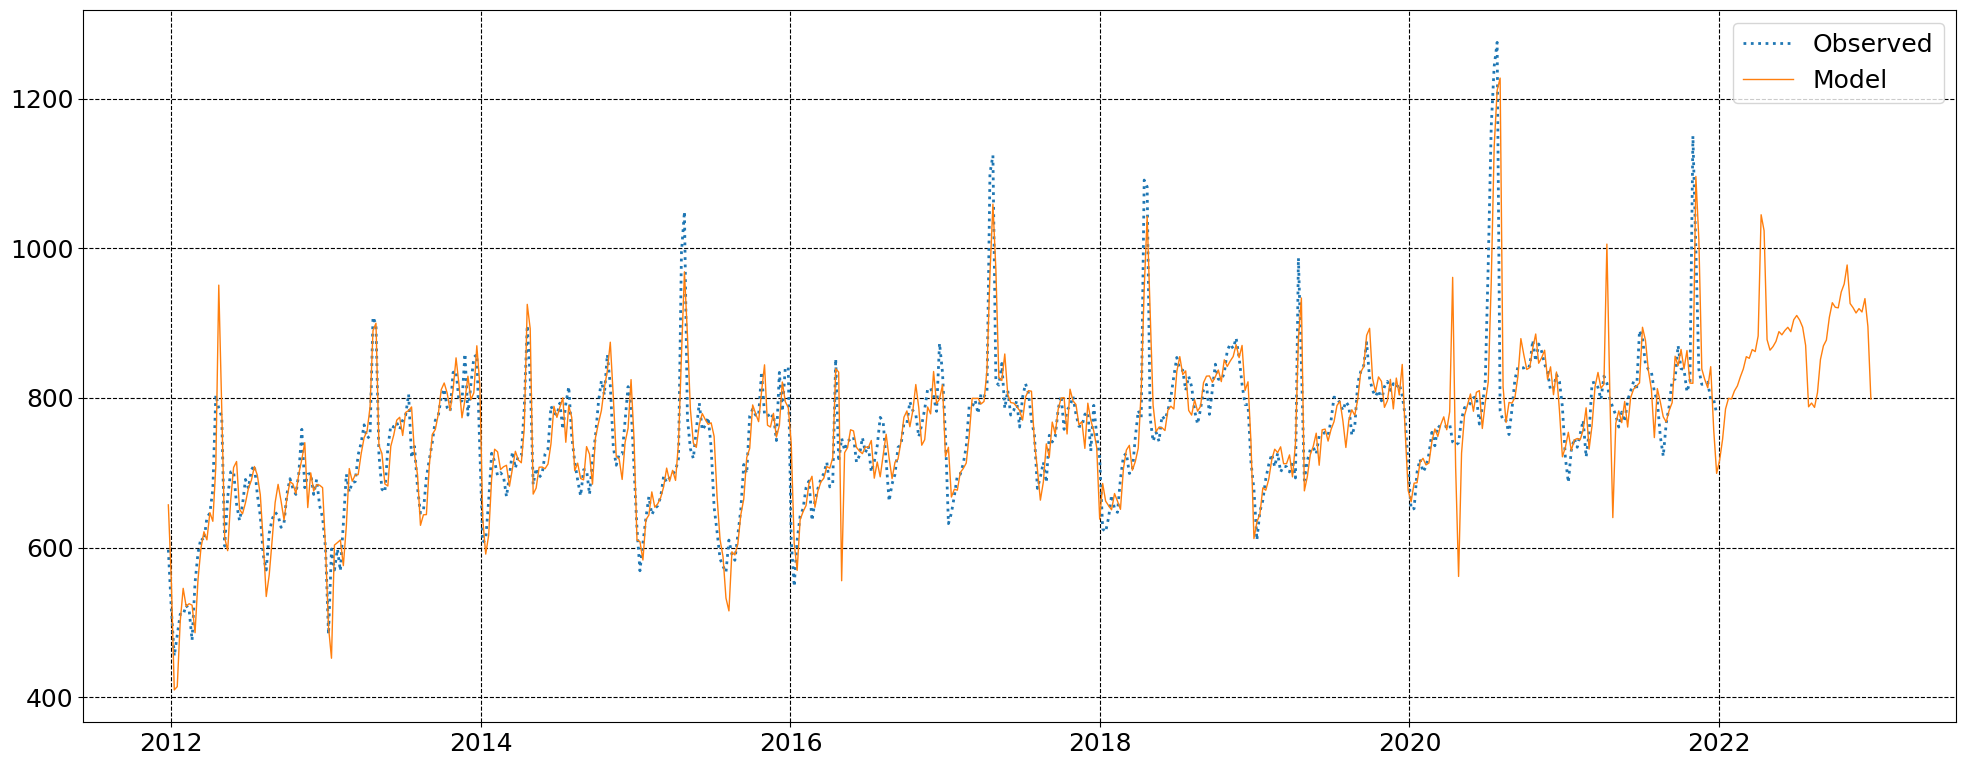

In [ ]:
model=ExponentialSmoothing(vald21_ts,damped_trend=False,trend='add',seasonal='add',seasonal_periods=52*1,initialization_method='estimated')
mod_result=model.fit()
forecast22=mod_result.forecast(52)
mod_net=pd.concat([mod_result.fittedvalues,forecast22])
fname=os.path.join(artikel_data_loc,'Forecast22.jpg')
ff.plot_mod_obs(vald21_ts,mod_net,fname)

In [ ]:
#2022 forecast time series
forecast_2022=mod_result.forecast(52)
forecast_2022=forecast_2022.round()
df=pd.DataFrame(forecast_2022,columns=['Net_Artikels'])
fname=os.path.join(artikel_data_loc,'forecast_22.csv')
pd.Series.to_csv(df,fname)